***Intervals of 0.25 hours. 
 241 time steps***
0.0 1 [1. 1. 1. 1. 1. 1.]
0.01 1 [1. 1. 1. 1. 1. 1.]
0.02 1 [1. 1. 1. 1. 1. 1.]
0.03 1 [1. 1. 1. 1. 1. 1.]
0.04 1 [1. 1. 1. 1. 1. 1.]
0.05 1 [1. 1. 1. 1. 1. 1.]
0.06 1 [1. 1. 1. 1. 1. 1.]
0.07 1 [1. 1. 1. 1. 1. 1.]
0.08 1 [1. 1. 1. 1. 1. 1.]
0.09 1 [1. 1. 1. 1. 1. 1.]
0.1 1 [1. 1. 1. 1. 1. 1.]
0.11 1 [1. 1. 1. 1. 1. 1.]
0.12 1 [1. 1. 1. 1. 1. 1.]
0.14 1 [1. 1. 1. 1. 1. 1.]
0.15 1 [1. 1. 1. 1. 1. 1.]
0.16 1 [1. 1. 1. 1. 1. 1.]
0.17 1 [1. 1. 1. 1. 1. 1.]
0.18 1 [1. 1. 1. 1. 1. 1.]
0.19 1 [1. 1. 1. 1. 1. 1.]
0.2 1 [1. 1. 1. 1. 1. 1.]
0.21 1 [1. 1. 1. 1. 1. 1.]
0.22 1 [1. 1. 1. 1. 1. 1.]
0.23 1 [1. 1. 1. 1. 1. 1.]
0.24 1 [1. 1. 1. 1. 1. 1.]
0.25 1 [1. 1. 1. 1. 1. 1.]
0.26 1 [1. 1. 1. 1. 1. 1.]
0.27 1 [1. 1. 1. 1. 1. 1.]
0.28 1 [1. 1. 1. 1. 1. 1.]
0.29 1 [1. 1. 1. 1. 1. 1.]
0.3 1 [1. 1. 1. 1. 1. 1.]
0.31 1 [1. 1. 1. 1. 1. 1.]
0.32 1 [1. 1. 1. 1. 1. 1.]
0.33 1 [1. 1. 1. 1. 1. 1.]
0.34 1 [1. 1. 1. 1. 1. 1.]
0.35 1 [1. 1. 1. 1. 1. 1.]
0.36 1 [1. 

Text(0.5, 0, 'Time [h]')

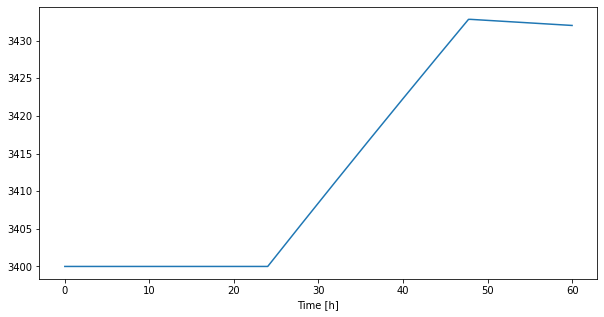

In [7]:
''' Current version of AD_OCS model. Define the input according to the defined unit of measure from the spreadsheet.
    Define the timespan in hours.'''

import math
from pprint import pprint as pp
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from SS_Algebraic import*
from dataimport import*
from PhysConstants  import*

from functions import gompertz, growth_SRB, f_deviations, deviations_check, level_t, headspace_dynamics_discr
from models import AD_OCS, AMOCO_HN
from mix_real_gas import f_VL_realgas


# System definition
d_start = 0         # [h] - Start time
d_end   = 60        # [h] - End time
hours   = .25     # [h] - Discretization time
n_times = int((d_end-d_start)/hours)+1 # Number of time steps

print('***Intervals of {hours} hours. \n {n_times} time steps***'.format(hours=hours, n_times=n_times))

t_span = np.linspace(d_start,d_end,n_times) # time span
t_span_d = t_span/24 # time span in days

y_influent_changes = f_deviations(t_span_d, T3.index.values, y_in_0) # Get the deviated influent values at each timestamp
y_influent = y_influent_changes[:,0:5] # Remove the Q_in values

Q_in = y_influent_changes[:,5] # Remove the y_in values

# --------------------------------------------------------------------------------------------
# Ode Integration of AMOCO_HN: use to get X2 
# --------------------------------------------------------------------------------------------

y0= [SSTATE[0], SSTATE[1], SSTATE[2], SSTATE[3], SSTATE[4], SSTATE[5], SSTATE[6]] # initial conditions esxkcdlished from SS

YOUT_pre = odeint(AMOCO_HN, y0, t_span_d, hmax = (t_span_d[1]-t_span_d[0]), args=(alfa, mu_max, Ks, KI2, KH, Pt, kLa, D, k, kd, N_bac, N_S1, y0[2], t_span[0], y_in_0, T3.index.values))
X2_pre = YOUT_pre[:,2]
print('************** AMOCOHN OK *******************')

# --------------------------------------------------------------------------------------------
# Ode Integration of the AD_OCS_Model: uses the previous X2 to get rho
# --------------------------------------------------------------------------------------------

y0 = [SSTATE[0], SSTATE[1], SSTATE[2], SSTATE[3], SSTATE[4], SSTATE[5], SSTATE[6]] # initial conditions esxkcdlished from SS

YOUT = odeint(AD_OCS, y0, t_span_d, hmax = (t_span_d[1]-t_span_d[0]), args=(alfa, mu_max, Ks, KI2, KH, Pt, kLa, D, k, kd, N_bac, N_S1, y0[2], t_span[0], y_in_0, T3.index.values, X2_pre, t_span_d))

# Get results
XT = YOUT[:,0]              # [gCOD/L] - Particulate 
X1 = YOUT[:,1]              # [g/L]    - Acidogenics  Bacteria  
X2 = YOUT[:,2]              # [g/L]    - Methanogenic Bacteria
Z  = YOUT[:,3]              # [mmol/L] - Total Alkalinity
S1 = YOUT[:,4]              # [g/L]    - Organic Soluble Substrate
S2 = YOUT[:,5]              # [mmol/L] - VFA dissolved
C  = YOUT[:,6]              # [mmol/L] - Inorganic Carbon Dissolved

print('************** AD_OCS OK *******************')

# Solver Output: from all the variables from the ones of the ODE
mu1 = np.empty(len(XT))
mu2 = np.empty(len(XT))
CO2 = np.empty(len(XT))
B   = np.empty(len(XT))
phi = np.empty(len(XT))
p_C = np.empty(len(XT))
q_C = np.empty(len(XT))
q_M_u = np.empty(len(XT))
pH  = np.empty(len(XT))

for x in range(len(t_span)):
    mu1[x] = mu_max[0]*(S1[x]/(S1[x]+Ks[0]))                     # [1/d]      - Specific Growth Rate for X1 (Monod)
    mu2[x] = mu_max[1]*(S2[x]/(S2[x]+Ks[1]+S2[x]**2/KI2))        # [1/d]      - Specific Growth Rate for X2 (Haldane)
    CO2[x] = C[x] + S2[x] - Z[x]                                 # [mmol/L]   - Dissolved CO2
    B[x]   = Z[x] - S2[x]                                        # [mmol/L]   - Alkalinity
    phi[x] = CO2[x] + KH*Pt + k[5]/kLa*mu2[x]*X2[x]
    p_C[x]  = (phi[x] - (phi[x]**2- 4*KH*Pt*CO2[x])**0.5)/(2*KH) # [atm]      - CO2 Partial Pressure
    q_C[x] = kLa*(CO2[x] - KH*p_C[x])                            # [mmol/L/d] - CO2 Outlet Molar Flow
    q_M_u[x] = k[5]*mu2[x]*X2[x]                                   # [mmol/L/d] - CH4 Outlet Molar Flow
    pH[x]  = np.real(-np.log10(Kb*CO2[x]/B[x]))                  # [-]        - System pH




# Sulfur and Oxygen Influence Evaluation

Xs     = np.zeros(len(t_span))                                   # [g/L]      - Sulfate Reducing Bacteria
Ss     = np.zeros(len(t_span))                                   # [mmol/L]      - Sulfur dissolved
y_S = np.zeros(len(t_span))                                      # [-]        - Sulfur Mole fraction in gas phase
Ss_max = np.zeros(len(t_span))                                   # [mmol/L]      - Maximum Sulfur dissolved concentration
Xs_max = np.zeros(len(t_span))                                   # [g/L]      - Maximum Sulfate Reducing Bacteria concentration (Gompertz Asymptote)
mu_srb = np.zeros(len(t_span))                                   # [g/L/d]    - Gompertz parameter for SRB growth
growth_rate = np.zeros(len(t_span))                              # [g/L/d]    - Gompertz derivative: states the growth rate of SRB

dXsdt = np.zeros([len(t_span),len(t_span)])                     # [g/L/d]    - SRB growth rate matrix, preallocation
lam = 0                                                         # [-]        - Lag Time as defined by Gompertz

for j in range(len(t_span)):
    # Iterate over each time step
    t = t_span[j]    
    if t < T3.index.values[index]*24:
        t_change_loc = 0

    elif t >= T3.index.values[-1]*24:
        t_change_loc = T3.index.values[index]*24  
        
    else:    
        t_change_loc = T3.index.values[index]*24       
        index = min(index + 1, len(T3.index.values)-1)  

    Ss_max[j] = frac_sulfur*y_influent[j,4]*1000/64*S2[j]/y_influent[0,4]
    Xs_max[j] = Y_srb/(1-Y_srb)*Ss_max[j]     
    
    # Gompertz function for microbial population and dissolved sulfur
    mu_srb[j] = (- X2[0] + X2[j])/max(1e-14,t_span[j]-t_span[0])            # [g/L/d]    - Gompertz parameter for SRB growth
    Xs[j]  = gompertz(t_span[j]-t_change_loc, Xs_max[j], mu_srb[j], lam)    # [g/L]      - Sulfate Reducing Bacteria - Gompertz
    Ss[j]  = Xs[j]*(1-Y_srb)/(Y_srb)                                        # [g/L]      - Sulfur dissolved concentration
        
    for snapshot in range(len(t_span)):        
        mu_srb_loc = np.nan_to_num((- X2[0] + X2[snapshot])/(max(1e-14,t_span[snapshot] - t_span[0])), nan=0, neginf=0)    # [g/L/d]    - Gompertz parameter for SRB growth, local  
        dXsdt[j, snapshot] = growth_SRB(t_span[snapshot], Xs_max[j], mu_srb_loc, lam)                     # [g/L/d]    - SRB growth rate matrix, local (Gompertz Derivative)
    
        growth_rate[j] = np.nanmax(dXsdt[j])                  # [g/L/d]    - Get the growth rate of SRB at each time step as the maximum of the possible rates

    y_S[j]   = (KH_S*Ss[j])/P_dig                             # [-]        - Sulfur Mole fraction in gas phase (G/L equilibrium)


I_Ss = 1-KI_SS*Ss                                         # [-]   - Sulfate Ion concentration  
q_M  = q_M_u*I_Ss
q_tot = q_C + q_M                                                # [mmol/L/d] - Outlet global molar flow  
q_S = y_S*q_tot                                               # [mmol/L/d] - Sulfur Outlet Specific Molar Flow
### Assess the liquid volume dynamics
h = np.zeros(len(t_span))
h0 = h_SS
t_change = t_span[0]
index = 0
V_liq = np.zeros(len(t_span))                                 # [m3] - Liquid Volume

for i in range(len(t_span)):
    t = t_span[i]    
    if t < T3.index.values[index]*24:
        pass

    elif t >= T3.index.values[-1]*24:
        t_change = T3.index.values[index]*24  
        h0 = h[len(t_span[t_span < t_change])-1]
        
    else:    
        t_change = T3.index.values[index]*24       
        h0 = h[i-1]
        index = min(index + 1, len(T3.index.values)-1)  
                
    h[i] = level_t(t, D, Q_in[i], SR, h0, t_change)
    V_liq[i] = np.pi*Dr**2*h[i]/4                             # [m3] - Liquid Volum
    if h[i] > hmax:
        print('!!! Level is too high !!!')
        input('Press Enter to continue')
    elif h[i] < hmin:
        print('!!! Level is too low !!!')
        input('Press Enter to continue')
plt.figure(figsize=(10,5))
plt.plot(t_span, V_liq)
plt.xlabel('Time [h]')

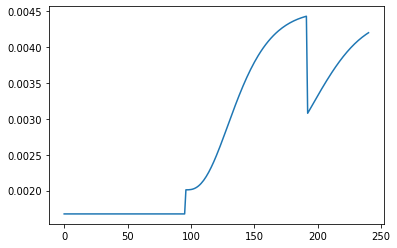

In [8]:
plt.plot(Xs)

In [15]:
h = np.zeros(len(t_span))
h0 = h_SS
t_change = t_span[0]
index = 0
V_liq = np.zeros(len(t_span))                                 # [m3] - Liquid Volume


In [16]:
index = 0

for i in range(len(t_span)):
    t = t_span[i]    
    if t < T3.index.values[index]*24:
        pass

    elif t >= T3.index.values[-1]*24:
        t_change = T3.index.values[index]*24  
        h0 = h[len(t_span[t_span < t_change])-1]
        
    else:    
        t_change = T3.index.values[index]*24       
        h0 = h[i-1]
        index = min(index + 1, len(T3.index.values)-1)   
                
    h[i] = level_t(t, D, Q_in[i], SR, h0, t_change)
    V_liq[i] = np.pi*Dr**2*h[i]/4                             # [m3] - Liquid Volume

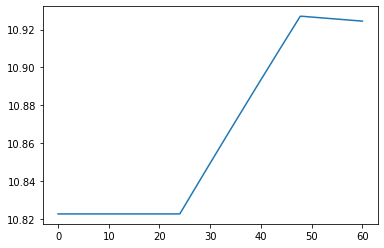

In [19]:

plt.plot(t_span, h)